<a href="https://colab.research.google.com/github/Srivardini11/lark/blob/main/Photometric_Flicker_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [1]:
!pip install lightkurve --quiet

     |████████████████████████████████| 247 kB 5.5 MB/s 
     |████████████████████████████████| 98 kB 7.0 MB/s 
     |████████████████████████████████| 41 kB 175 kB/s 
     |████████████████████████████████| 4.5 MB 48.6 MB/s 
     |████████████████████████████████| 832 kB 46.2 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 3.6 MB 37.2 MB/s 


# **Import**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib 
import lightkurve as lk
import numpy as np
from astropy.modeling import fitting, models
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
from google.colab import files
from scipy.interpolate import interp1d
from astropy.modeling import fitting, models
from astropy.stats import sigma_clip
import seaborn as sb

matplotlib.rcParams['figure.figsize'] = (15,8)
sb.set_style('darkgrid')

# **GitHub**

In [3]:
!git clone https://github.com/Srivardini11/lark

Cloning into 'lark'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 135 (delta 42), reused 0 (delta 0), pack-reused 34
Receiving objects: 100% (135/135), 7.31 MiB | 10.62 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [4]:
cd lark/data

/content/lark/data


# **Data**

In [5]:
with open('Fabienne.txt',mode='r') as f:
  dat = f.readlines()
  f.close()
col_names = dat[5].split()[1:]

data = []
for i in dat[6:]:
  data.append([float(j) for j in i.split()])

df = pd.DataFrame(data, columns=col_names)

In [6]:
df

,KepID,KepMag,Teff(SDSS),F_8(Corr),R(Corr),Zcross
0,1164109.0,10.88,6607.0,0.0630,3.68,27.0
1,1725815.0,10.83,6550.0,0.0497,0.28,75.0
2,1868918.0,11.56,6252.0,0.0470,0.43,84.0
3,2010835.0,11.33,6103.0,0.0530,0.14,245.0
4,2013883.0,11.21,6278.0,0.0556,0.48,32.0
...,...,...,...,...,...,...
537,12555505.0,9.62,5704.0,0.0298,0.29,49.0
538,12600459.0,10.41,6303.0,0.0409,0.43,93.0
539,12602236.0,10.15,6522.0,0.0447,0.89,65.0
540,12690331.0,11.48,6626.0,0.0668,0.51,67.0


In [30]:
sample=[5449910.,4543923.0,9657636.0, 8779965.0, 3939679.0, 11083613.0]

The data used by Bastien is used to crosscheck the working of the code. First, the outliers were removed from the lightcurves. The scattered points are interpolated from the flux values over the time period of nineth quarter. To get the flicker, a third order polynomial is fit. The curves are sigma clipped and using Boxcar fitting, the rms is found. The  

In [ ]:
download = 0
flr_rms_list  = []
flkr_list     = []
logg_list     = []

count = 0
for id in df['KepID']:
  name    = id
  source  = lk.search_lightcurve(name, author="Kepler", cadence="long",quarter = 9).download()
  count+=1
  
  # Removing outliers
  rem_out = source.remove_nans().remove_outliers()
  
  test = rem_out.flatten(polyorder=3)

  flux    = rem_out.flux.value
  time    = rem_out.time.value

  # Interpolating data
  f = interp1d(time,flux)
  size = len(time)*3      # Size increased 3 times
  x = np.linspace(time.min(), time.max(),size)
  y = f(x)

  # Fitting a polynomial of order 3
  init = models.Polynomial1D(3)

  fit  = fitting.LevMarLSQFitter()

  model = fit(init,x,y)
  
  # Model subtraction
  data = y-model(x)

  # Sigma clipping

  flux_out = sigma_clip(data,sigma=2.5)

  mult = size/((time.max()-time.min())*24)

  # Box smoothening with Box size = 8 hours

  smoothed_signal = convolve(flux_out, Box1DKernel(8*mult),boundary='extend')

  flicker = flux_out-smoothed_signal

  flr_rms_list.append(np.sqrt( (flicker**2).mean()))

  logg_list.append(source.LOGG) 

The table is added with the calculated Flickers and the error percentage is obtained. 

In [71]:
df['LogG'] = logg_list
flickers = np.array(flr_rms_list)/1000
df['F_8(Calculated)'] = flickers
f8_error = (df['F_8(Corr)'].values - df['F_8(LK)'].values)/df['F_8(Corr)'].values
df['F8_error'] = f8_error
df

,KepID,KepMag,Teff(SDSS),F_8(Corr),R(Corr),Zcross,LogG,F_8(LK),F_8(Calculated),F8_error
0,1164109.0,10.88,6607.0,0.0630,3.68,27.0,4.105,0.036239,0.036239,0.424779
1,1725815.0,10.83,6550.0,0.0497,0.28,75.0,3.982,0.027745,0.027745,0.441755
2,1868918.0,11.56,6252.0,0.0470,0.43,84.0,4.207,0.016118,0.016118,0.657059
3,2010835.0,11.33,6103.0,0.0530,0.14,245.0,4.125,0.019205,0.019205,0.637644
4,2013883.0,11.21,6278.0,0.0556,0.48,32.0,4.456,0.023834,0.023834,0.571323
...,...,...,...,...,...,...,...,...,...,...
537,12555505.0,9.62,5704.0,0.0298,0.29,49.0,4.380,0.051143,0.051143,-0.716209
538,12600459.0,10.41,6303.0,0.0409,0.43,93.0,4.303,0.032567,0.032567,0.203731
539,12602236.0,10.15,6522.0,0.0447,0.89,65.0,4.196,0.058380,0.058380,-0.306044
540,12690331.0,11.48,6626.0,0.0668,0.51,67.0,3.969,0.017994,0.017994,0.730630


The flickers calculated are plotted with the range and log g.

Text(0, 0.5, '$\\log_{10}[R_{var}$(p.p.t Kepmag corrected)]')

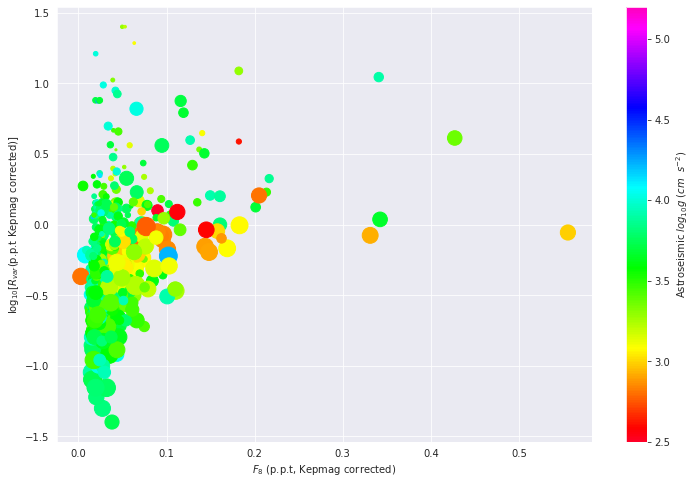

In [ ]:
x = df['F_8(Calculated)']
y = np.log10(df['R(Corr)'])
c = df['LogG']
s = df['Zcross']
plt.figure(figsize = (12,8))
img = plt.scatter(x,y,c=c*0.9,s=s*1.5,cmap='gist_rainbow',vmin=2.5,vmax=5.2)
plt.colorbar(img,label=r'Astroseismic $log_{10}g$ ($cm$  $s^{-2}$)')
plt.xlabel(r'$F_8$ (p.p.t, Kepmag corrected)')
plt.ylabel(r'$\log_{10}[R_{var}$(p.p.t Kepmag corrected)]')

The Flicker plot obtained from the data of Bastein.

Text(0, 0.5, '$\\log_{10}[R_{var}$(p.p.t Kepmag corrected)]')

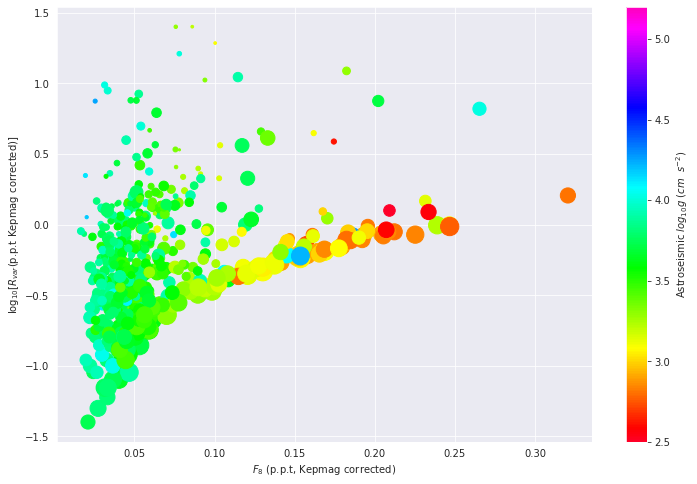

In [ ]:
 = df['F_8(Corr)']
y = np.log10(df['R(Corr)'])
c = df['LogG']
s = df['Zcross']
plt.figure(figsize = (12,8))
img = plt.scatter(x,y,c=c*0.9,s=s*1.5,cmap='gist_rainbow',vmin=2.5,vmax=5.2)
plt.colorbar(img,label=r'Astroseismic $log_{10}g$ ($cm$  $s^{-2}$)')
plt.xlabel(r'$F_8$ (p.p.t, Kepmag corrected)')
plt.ylabel(r'$\log_{10}[R_{var}$(p.p.t Kepmag corrected)]')

The error is around 0 for some stars in the range 10 and 10.5 of Kep Meg. But some stars show a heavy difference in the F_8. But there is a pattern seen in the difference between the obtained flickers and from the paper. 

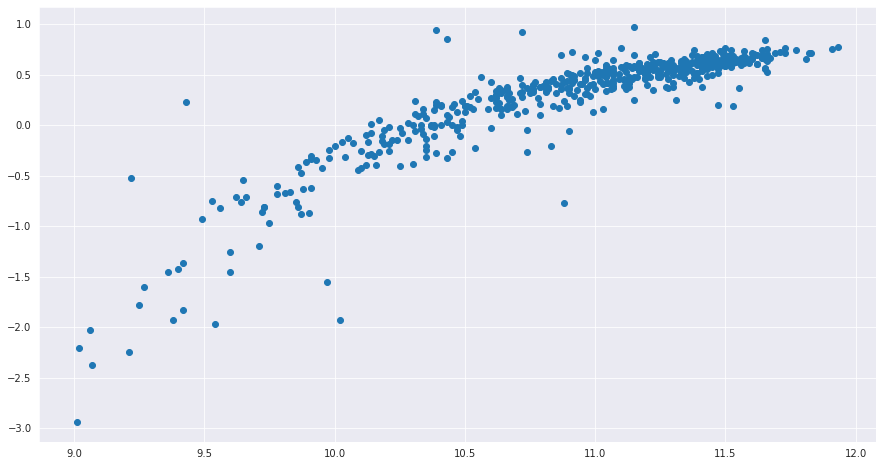

In [65]:
plt.scatter(df['KepMag'],f8_error)

In [72]:
table

,calc flicker,Bastien flicker,Flicker error,Kep Mag
0,0.017062,0.046,0.629089,11.235
1,0.018470,0.055,0.664183,11.623
2,0.017200,0.049,0.648975,11.253
3,0.015613,0.067,0.766977,11.730
4,0.069273,0.171,0.594896,11.099
5,0.083925,0.284,0.704490,11.629


In [40]:
 flickers = np.array(flr_rms_list)/1000
 flickers

array([0.01706189, 0.01846995, 0.01720024, 0.01561255, 0.06927283,
       0.08392491])

10000 = 21600 hours

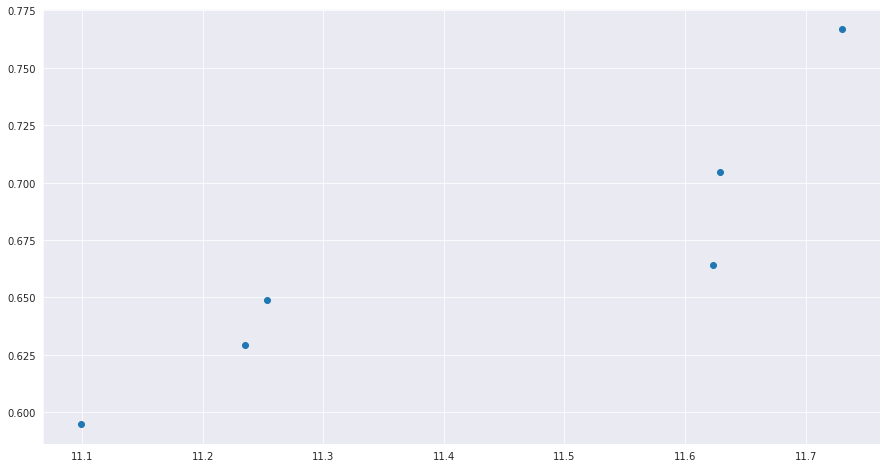

In [49]:
Kep_Magnitude = np.array([11.235, 11.623, 11.253, 11.730, 11.099, 11.629])
F8_pap= np.array([0.046, 0.055, 0.049, 0.067, 0.171, 0.284]) 
f8_diff = (F8_pap - flickers)/F8_pap
plt.scatter(Kep_Magnitude,f8_diff)

In [50]:
sum={'calc flicker':flickers,'Bastien flicker':F8_pap, 'Flicker error':f8_diff, 'Kep Mag': Kep_Magnitude}
table=pd.DataFrame(sum)
table

,calc flicker,Bastien flicker,Flicker error,Kep Mag
0,0.017062,0.046,0.629089,11.235
1,0.018470,0.055,0.664183,11.623
2,0.017200,0.049,0.648975,11.253
3,0.015613,0.067,0.766977,11.730
4,0.069273,0.171,0.594896,11.099
5,0.083925,0.284,0.704490,11.629
